# Throw like you Catch
### End-to-end Robotic Throwing and Catching system
### 6.843 Final Project at MIT by David von Wrangel, Ria Sonecha, Shreya Prandit
#### Run this notebook and see for yourself

In [ ]:
from pydrake.all import (
    DiagramBuilder,
    AddMultibodyPlantSceneGraph,
    Parser,
    PassThrough,
    Demultiplexer,Multiplexer,
    MultibodyPlant,
    InverseDynamicsController,
    Adder,
    JacobianWrtVariable,
    StateInterpolatorWithDiscreteDerivative,
    SchunkWsgPositionController,
    MakeMultibodyStateToWsgStateSystem,
    SpatialVelocity,SpatialInertia, UnitInertia,
    RigidTransform, RollPitchYaw, RotationMatrix,
    Sphere, Box, 
    SnoptSolver,
    AbstractValue,
    ConstantVectorSource, TrajectorySource,
    MeshcatVisualizerCpp, MeshcatVisualizerParams, 
    CoulombFriction,
    MeshcatVisualizer,
    Simulator, Integrator, DiscreteDerivative,
    PiecewisePose,BasicVector,
    PiecewiseQuaternionSlerp,PiecewisePolynomial,
    FindResourceOrThrow,
    Solve, MathematicalProgram,eq, le, ge,
    LeafSystem, FixedOffsetFrame,
    DifferentialInverseKinematicsParameters,DifferentialInverseKinematicsIntegrator,DoDifferentialInverseKinematics, 
    AddFrame, Frame,FixedOffsetFrame,
)
from itertools import groupby
from pydrake.multibody import inverse_kinematics
from manipulation.scenarios import AddRgbdSensors, AddShape
from manipulation.utils import FindResource
from manipulation.meshcat_cpp_utils import StartMeshcat, AddMeshcatTriad


import numpy as np
import matplotlib.pyplot as plt 
import altair as alt
import ipywidgets
import pydot
import pydrake.all
import os
from IPython.display import display, SVG, HTML

## 1. Parameters and Helper functions to create the Kuka iiwa7 with a Tennisball
#### Click on the meshcat link to view the simulation once you ran the rest

In [ ]:
meshcat = StartMeshcat()

In [ ]:
#parameters
sphere_mass = 0.056
sphere_color = np.array([223,255,79,255])/255
sphere_mu = 0.8
sphere_r = 0.033

In [ ]:
def AddIiwa(plant, collision_model="no_collision", offset = RigidTransform(RotationMatrix(), [0,0,0]), name = "iiwa"):
    sdf_path = pydrake.common.FindResourceOrThrow(
        "drake/manipulation/models/iiwa_description/iiwa7/"
        f"iiwa7_{collision_model}.sdf")

    parser = pydrake.multibody.parsing.Parser(plant)
    iiwa = parser.AddModelFromFile(sdf_path, name)
    plant.WeldFrames(plant.world_frame(), plant.GetFrameByName("iiwa_link_0",iiwa), offset)

    # Set default positions:
    q0 = [0.0, 0.1, 0, -1.2, 0, 1.6, 0]
    index = 0
    for joint_index in plant.GetJointIndices(iiwa):
        joint = plant.get_mutable_joint(joint_index)
        if isinstance(joint, pydrake.multibody.tree.RevoluteJoint):
            joint.set_default_angle(q0[index])
            index += 1

    return iiwa


def AddWsg(plant, iiwa_model_instance, roll=np.pi / 2.0, welded=False, name = "gripper"):
    parser = pydrake.multibody.parsing.Parser(plant)
    if welded:
        parser.package_map().Add(
            "wsg_50_description",
            os.path.dirname(
                pydrake.common.FindResourceOrThrow(
                    "drake/manipulation/models/wsg_50_description/package.xml"))
        )
        gripper = parser.AddModelFromFile(
            FindResource("models/schunk_wsg_50_welded_fingers.sdf"), name)
    else:
        gripper = parser.AddModelFromFile(
            pydrake.common.FindResourceOrThrow(
                "drake/manipulation/models/"
                "wsg_50_description/sdf/schunk_wsg_50_no_tip.sdf"), name)
    
    X_7G = RigidTransform(RollPitchYaw(np.pi / 2.0, 0, roll), [0, 0, 0.114])
    plant.WeldFrames(plant.GetFrameByName("iiwa_link_7", iiwa_model_instance),
                     plant.GetFrameByName("body", gripper), X_7G)

    #wsg_offset = RigidTransform(RotationMatrix(), [0,0.11,0]) #This is where it will grab the sphere
    #wsg_offset_frame = FixedOffsetFrame("wsg_offset",plant.GetFrameByName("body"), wsg_offset)	 
    #plant.AddFrame(wsg_offset_frame)

    return gripper
    
def CreateIiwaControllerPlant(offset = RigidTransform(RotationMatrix(), [0,0,0])):
    """creates plant that includes only the robot and gripper, used for controllers."""
    sim_timestep = 1e-3
    plant_robot = MultibodyPlant(sim_timestep)
    iiwa = AddIiwa(plant_robot,offset=offset)
    wsg = AddWsg(plant_robot, iiwa, welded = True)  #need to weld it for diffIK so that jaws don't have Dofs

    plant_robot.mutable_gravity_field().set_gravity_vector([0, 0, 0])
    plant_robot.Finalize()

    context = plant_robot.CreateDefaultContext()

    q0 = plant_robot.GetPositions(context)
    return plant_robot, q0

In [ ]:
class PoseSource(LeafSystem):
    def __init__(self, traj):
        LeafSystem.__init__(self)
        self.traj = traj
        self.DeclareAbstractOutputPort("Pose", lambda: AbstractValue.Make(RigidTransform()),self.CalcPose)
        self.DeclareVectorOutputPort("Velocity", BasicVector(6), self.CalcVelocity)
        self.DeclareVectorOutputPort("Acceleration", BasicVector(6), self.CalcAcceleration)
    
    def CalcPose(self, context, output):
        output.set_value(self.traj.GetPose(context.get_time()))
    
    def CalcVelocity(self, context, output):
        output.set_value(self.traj.GetVelocity(context.get_time()))

    def CalcAcceleration(self, context, output):
        output.set_value(self.traj.GetAcceleration(context.get_time()))

### Reducing Lag is Key!
To get the most out of the Iversedynamics controller, we made an optimization based Differential Inverse dyanmics controller that takes account for singularities. While respecting joint limits, the controller returns desired joint velocities where the integral and derivatives yield smooth joint positions and accelerations.

In [ ]:
class DifferentialIKCL(LeafSystem):
    """
    A simple system that wraps calls to the DifferentialInverseKinematics API
    Here, we also feed in the measured positions by the iiwa plant to reduce lag
    """
    def __init__(self, robot, frame_E, parameters):
        LeafSystem.__init__(self)
        self.robot = robot
        self.frame_E = frame_E
        self._iiwa = robot.GetModelInstanceByName("iiwa")

        self.parameters = parameters
        self.robot_context = robot.CreateDefaultContext()
        # Confirm that all velocities are zero (they will BE be reset below).
        assert not self.robot.GetPositionsAndVelocities(self.robot_context)[-robot.num_velocities():].any()


        #set input port
        self.V_port = self.DeclareVectorInputPort("V_WE_desired", BasicVector(6))
        self.q_port = self.DeclareVectorInputPort("iiwa_position", BasicVector(7))

        # Provide the output as desired positions.
        self.DeclareVectorOutputPort("iiwa_velocity",BasicVector(7), self.CalcOutput)

    def CalcOutput(self, context, output):
        V_WE_desired = self.V_port.Eval(context)
        q = self.q_port.Eval(context)
        self.robot.SetPositions(self.robot_context, self._iiwa, q)


        result = DoDifferentialInverseKinematics(self.robot,
                                                 self.robot_context,
                                                 V_WE_desired, self.frame_E,
                                                 self.parameters)
        if (result.status != result.status.kSolutionFound):
            print("Differential IK could not find a solution.")

        output.SetFromVector(result.joint_velocities)

In [ ]:
def MakeManipulationStation(time_step=0.002, offset = RigidTransform(RotationMatrix(), [0,0,0])):
    builder = DiagramBuilder()

    # Add (only) the iiwa, WSG, and cameras to the scene.
    plant, scene_graph =AddMultibodyPlantSceneGraph(
        builder, time_step=time_step)
    
    #plant.mutable_gravity_field().set_gravity_vector(gravity)
    iiwa = AddIiwa(plant, offset = offset)
    wsg = AddWsg(plant, iiwa)
    Parser(plant).AddModelFromFile(
        FindResource("models/camera_box.sdf"), "camera0")

    # add ground
    Parser(plant).AddModelFromFile('ground.urdf', "ground")

    # add tennisball
    AddShape(plant, Sphere(sphere_r), name="sphere", mass=sphere_mass, mu=sphere_mu, color=sphere_color)
    sphere = plant.GetBodyByName("sphere")     

    plant.Finalize()

    num_iiwa_positions = plant.num_positions(iiwa)

    # I need a PassThrough system so that I can export the input port.
    iiwa_state = builder.AddSystem(PassThrough(num_iiwa_positions +  plant.num_velocities(iiwa)))
    builder.ExportOutput(iiwa_state.get_output_port(), "iiwa_state_command")

    iiwa_velocity = builder.AddSystem(PassThrough(6))
    builder.ExportInput(iiwa_velocity.get_input_port(), "iiwa_velocity")
    builder.ExportOutput(iiwa_velocity.get_output_port(), "iiwa_velocity_command")

    # Export the iiwa "state" outputs.
    demux = builder.AddSystem(Demultiplexer(
        2 * num_iiwa_positions, num_iiwa_positions))
    builder.Connect(plant.get_state_output_port(iiwa), demux.get_input_port())
    builder.ExportOutput(demux.get_output_port(0), "iiwa_position_measured")
    builder.ExportOutput(demux.get_output_port(1), "iiwa_velocity_estimated")
    builder.ExportOutput(plant.get_state_output_port(iiwa), "iiwa_state_estimated")

    # Make the plant for the iiwa controller to use.
    controller_plant = MultibodyPlant(time_step=time_step)
    controller_iiwa = AddIiwa(controller_plant, offset = offset)
    AddWsg(controller_plant, controller_iiwa, welded=True)
    controller_plant.Finalize()

    # Add the iiwa controller
    iiwa_controller = builder.AddSystem(
        InverseDynamicsController(
            controller_plant,
            kp=[100]*num_iiwa_positions,
            ki=[1]*num_iiwa_positions,
            kd=[20]*num_iiwa_positions,
            has_reference_acceleration=True))
    iiwa_controller.set_name("iiwa_controller")
    builder.Connect(
        plant.get_state_output_port(iiwa), iiwa_controller.get_input_port_estimated_state())

    # Add in the feed-forward torque
    adder = builder.AddSystem(Adder(2, num_iiwa_positions))
    builder.Connect(iiwa_controller.get_output_port_control(),
                    adder.get_input_port(0))
    # Use a PassThrough to make the port optional (it will provide zero values if not connected).
    torque_passthrough = builder.AddSystem(
        PassThrough([0]*num_iiwa_positions))
    builder.Connect(torque_passthrough.get_output_port(), adder.get_input_port(1))
    builder.ExportInput(torque_passthrough.get_input_port(), "iiwa_feedforward_torque")
    builder.Connect(adder.get_output_port(), plant.get_actuation_input_port(iiwa))

    builder.Connect(iiwa_state.get_output_port(), iiwa_controller.get_input_port_desired_state())

    # Export commanded torques.
    #builder.ExportOutput(adder.get_output_port(), "iiwa_torque_commanded")inverse_kinematics
    #builder.ExportOutput(adder.get_output_port(), "iiwa_torque_measured")

    # DiffIK Controller
    plant_robot, _ = CreateIiwaControllerPlant(offset = offset) #create for controller

    params = DifferentialInverseKinematicsParameters(plant_robot.num_positions(),plant_robot.num_velocities())
    params.set_timestep(time_step)
    
    #iiwa7_velocity_limits = np.array([1.71, 1.71,1.745, 2.26, 2.44, 3.14, 3.14])
    params.set_joint_velocity_limits((plant_robot.GetVelocityLowerLimits(),plant_robot.GetVelocityUpperLimits()))

    params.set_joint_position_limits((plant_robot.GetPositionLowerLimits(),plant_robot.GetPositionUpperLimits()))

    gripper_frame = plant_robot.GetBodyByName("body").body_frame()
    robot_context = plant_robot.CreateDefaultContext()

    DiffIK = builder.AddSystem(DifferentialIKCL(plant_robot, gripper_frame, params))                  
    #connect DiffIK
    builder.Connect(iiwa_velocity.get_output_port(), DiffIK.GetInputPort("V_WE_desired"))
    builder.Connect(demux.get_output_port(0), DiffIK.GetInputPort("iiwa_position"))

    integrator = builder.AddSystem(Integrator(7))
    integrator.set_name("integrator")
    builder.Connect(DiffIK.get_output_port(), integrator.get_input_port())

    mux = builder.AddSystem(Multiplexer([plant_robot.num_positions(), plant_robot.num_velocities()]))
    builder.Connect(integrator.get_output_port(), mux.get_input_port(0))
    builder.Connect(DiffIK.get_output_port(), mux.get_input_port(1) )
    builder.Connect(mux.get_output_port(), iiwa_state.get_input_port())

    #accelerations
    acceleration = builder.AddSystem(DiscreteDerivative(7, time_step))
    builder.Connect(DiffIK.get_output_port(),acceleration.get_input_port())
    builder.Connect(acceleration.get_output_port(),iiwa_controller.get_input_port_desired_acceleration())


    # Wsg controller.
    wsg_controller = builder.AddSystem(SchunkWsgPositionController(kp_command=2000.0, kd_command=5.0, kp_constraint=2000.0, kd_constraint=5.0, default_force_limit=40.0))
    wsg_controller.set_name("wsg_controller")
    builder.Connect(wsg_controller.get_generalized_force_output_port(),             
                    plant.get_actuation_input_port(wsg))
    builder.Connect(plant.get_state_output_port(wsg), wsg_controller.get_state_input_port())
    builder.ExportInput(wsg_controller.get_desired_position_input_port(), "wsg_position")
    builder.ExportInput(wsg_controller.get_force_limit_input_port(), "wsg_force_limit")
    wsg_mbp_state_to_wsg_state = builder.AddSystem(
        MakeMultibodyStateToWsgStateSystem())
    builder.Connect(plant.get_state_output_port(wsg), wsg_mbp_state_to_wsg_state.get_input_port())
    builder.ExportOutput(wsg_mbp_state_to_wsg_state.get_output_port(), "wsg_state_measured")
    builder.ExportOutput(wsg_controller.get_grip_force_output_port(), "wsg_force_measured")

    # Cameras.
    AddRgbdSensors(builder, plant, scene_graph)

    # Export "cheat" ports.
    builder.ExportOutput(scene_graph.get_query_output_port(), "geometry_query")
    builder.ExportOutput(plant.get_contact_results_output_port(), "contact_results")
    builder.ExportOutput(plant.get_state_output_port(), "plant_continuous_state")

    builder.ExportOutput(plant.get_body_poses_output_port(), "body_poses")
    builder.ExportOutput(plant.get_body_spatial_velocities_output_port(), "body_velocities")

    diagram = builder.Build()

    context = diagram.CreateDefaultContext()
    diagram.Publish(context)

    #init integrator
    q0 = diagram.GetOutputPort("iiwa_position_measured").Eval(context)
    integrator.set_integral_value(integrator.GetMyContextFromRoot(context),list(q0))

    return diagram, plant, integrator

diagram, plant,integrator = MakeManipulationStation()

#display(SVG(pydot.graph_from_dot_data(diagram.GetGraphvizString())[0].create_svg()))

### 2. Get the Sphere Trajectory
Given inital conditions of the Target, we simulate its trajectory while getting its poses and velocities at discret timesteps

In [ ]:
def GetSpherePose(time_delta, p_init, v_init, time_step=0.002):
    """
        Given an iniital translational positition/velocity we make an empty world
        with the ground being at 0
        This function will step through time, pull out the poses and velocities of the sphere and terminates
        when the ball crosses the Z threshold
    """
    z_threshold = 0.2
    builder = DiagramBuilder()

    plant, scene_graph =AddMultibodyPlantSceneGraph(builder, time_step=time_step)
    #plant.mutable_gravity_field().set_gravity_vector(gravity)
    # add ground
    Parser(plant).AddModelFromFile('ground.urdf', "ground")

    # add tennisball
    AddShape(plant, Sphere(sphere_r), name="sphere", mass=sphere_mass, mu=sphere_mu, color=sphere_color)
    sphere = plant.GetBodyByName("sphere")     

    plant.Finalize()

    diagram = builder.Build()

    simulator = Simulator(diagram)
    context = simulator.get_mutable_context()
    plant_context = plant.GetMyContextFromRoot(context)

    #initial condition
    v_WSphere = SpatialVelocity(w=[0, 0, 0], v=v_init)
    x_WSphere = RigidTransform(p=p_init)
    plant.SetFreeBodyPose(plant_context, sphere, x_WSphere)
    plant.SetFreeBodySpatialVelocity(context=plant_context, body=sphere, V_WB=v_WSphere)

    simulator.set_target_realtime_rate(0)


    pose_list = []
    V_list = []
    time_list = []
    t = 0
    while True:
        simulator.AdvanceTo(t)
        X = plant.get_body_poses_output_port().Eval(plant_context)[int(sphere.index())]
        V = plant.get_body_spatial_velocities_output_port().Eval(plant_context)[int(sphere.index())]

        Vx, Vy, Vz = V.translational()
        Px, Py, Pz = X.translation()
        
        if Pz < z_threshold:
            break
        pose_list.append(X)
        V_list.append(V)
        time_list.append(t)
        t += time_delta

    return pose_list, V_list, time_list

### 3. Lets Plan the Robot's trajectory to intercept it
To speed up computation, we rule out all sphere poses that are not within the reachable hemisphere.
Then, we use Inverse Kinematics to find continous segments along the Balls natural trajectory where we can intercept it while adhering to joint velocities and position constraints. Further, we force the grippers z-axis to be aligned with the velocity vector of the sphere so that it doesn't collide with the Jaws. We take the longest segment and run forward kinematics to find the new optimal poses for grasping the ball.

In [ ]:
def RunIKCatch(plant, q0, gripper_frame, pose_desired, velocity_vector, time_delta, velocity_lower_limit, velocity_upper_limit, enforce_velocity_constraint = False):
    ik = inverse_kinematics.InverseKinematics(plant)
    ik.AddPositionConstraint(
        gripper_frame, [0, 0.09, 0], plant.world_frame(), 
        pose_desired.translation(), pose_desired.translation())
    ik.AddAngleBetweenVectorsConstraint(gripper_frame, np.array([[0],[0],[1]]), plant.world_frame(), velocity_vector.translational().reshape(3,1), 0, 0)
    prog = ik.get_mutable_prog()
    q = ik.q()
    
    prog.AddQuadraticErrorCost(np.identity(len(q)), q0, q)
    if enforce_velocity_constraint:
        prog.AddBoundingBoxConstraint((velocity_lower_limit*time_delta) + q0, (velocity_upper_limit*time_delta) + q0, q)
    prog.SetInitialGuess(q, q0)
    result = Solve(ik.prog())
    if not result.is_success():
        # print("IK failed")
        return None
    q1 = result.GetSolution(q)
    return q1


In [ ]:
#trajectory matching
def filter_reachable_poses_reorientate(pose_lst,v_lst, t_lst, offset, t_init):
  ik_plant, q0 = CreateIiwaControllerPlant(offset = offset)
  ik_context = ik_plant.CreateDefaultContext()

  velocity_lower_bound = ik_plant.GetVelocityLowerLimits()
  velocity_upper_bound = ik_plant.GetVelocityUpperLimits()
  
  q_list = [q0]
  q_last_valid = q0

  world_frame = ik_plant.world_frame()
  gripper_frame = ik_plant.GetFrameByName("body")

  time_delta_list = list(np.array(t_lst[1:]) - np.array(t_lst[:-1]))
  for idx, (pose_desired, velocity_vector, time_delta) in enumerate(zip(pose_lst, v_lst, time_delta_list)):
    enforce_velocity_limit = True #always enforce velocity limit
    if np.all(q_last_valid == q0):
      enforce_velocity_limit = True
      time_delta = t_lst[idx] - t_init #lets see if we can even reach the trajectory in time

    q_next = RunIKCatch(ik_plant, q_last_valid, gripper_frame, pose_desired, velocity_vector, time_delta, velocity_lower_bound, velocity_upper_bound, enforce_velocity_limit)
    q_list.append(q_next)
    if q_next is None:
        q_last_valid = q0
    else:
        q_last_valid = q_next
 
  #lets output longest segment 
  #zip everything together
  qvt = list(zip(q_list,v_lst,t_lst))
  segments = [list(g) for k, g in groupby(qvt, lambda x: not x[0] is None) if k]
  best_segment = max(segments, key=len)

  #unzipo best segment 
  q_list, v_list, t_list = list(zip(*best_segment))

  #find new poses with forward kinematics
  def ForwardKinematics(q):
    ik_plant.SetPositions(ik_context, q)
    return ik_plant.EvalBodyPoseInWorld(ik_context, gripper_frame.body())

  new_pose_list = np.array(list(map(lambda q: ForwardKinematics(q), list(q_list))))

  return new_pose_list, np.array(v_list), np.array(t_list)
 

### 4. Resample timesteps for smooth inteception
Even though our DiffIK controller is amazing, there usually exists a very sharp corner between the Balls trajectory and the robot having to move to it from its inital configuration. To avoid that issue we just modify the arrival time such that we get to the Balls trajectory early, then match its trajectory. To avoid the ball slipping through the fingers after grasping it, we are slowly deaccelerating the Ball by stretching the time.

In [ ]:
def MakeCatchingTrajectory(X_Winit, V_Winit, t_init, p_init, v_init, offset, time_delta = 0.002, do_plots = False):
    #Get Sphere Trajectory given initial condition
    raw_pose_lst, raw_V_list, raw_t_lst = GetSpherePose(time_delta, p_init, v_init, time_step=time_delta/2)
    #offset times of sphere poses
    raw_t_lst = np.array(raw_t_lst) + t_init

    #Filter all Sphere poses that are definetly not reachable
    #raw_pose_lst is X_WSphere
    reach_readius = 1.2 #meter
    can_reach_start = 0
    can_reach_end = len(raw_pose_lst)-1
    for can_reach_start, X_WSphere in enumerate(raw_pose_lst):
        if np.linalg.norm(offset.inverse().multiply(X_WSphere).translation()) < reach_readius:
            # can reach it 
            break
    
    for can_reach_end, X_WSphere in list(enumerate(raw_pose_lst))[::-1]:
        if np.linalg.norm(offset.inverse().multiply(X_WSphere).translation()) < reach_readius:
            # can reach it 
            break

    raw_pose_lst, raw_V_list, raw_t_lst = raw_pose_lst[can_reach_start:can_reach_end], raw_V_list[can_reach_start:can_reach_end], raw_t_lst[can_reach_start:can_reach_end]
    
    X_reach, V_reach, time_reach = filter_reachable_poses_reorientate(raw_pose_lst, raw_V_list, raw_t_lst, offset, t_init)
    t_reach = 0.5 + t_init #this is how long it takes to get to any point 
    X_reach = X_reach[np.where(time_reach >= t_reach)]
    time_reach = time_reach[np.where(time_reach >= t_reach)]
    #print("can we make it?",time_reach[0])
    assert len(time_reach) > 5 #need at least 5
    follow_idx = int(0.5*len(time_reach))
    close_idx = int(0.6*len(time_reach))
    slow_down_idx = int(0.7*len(time_reach))-1

    t_follow = time_reach[follow_idx:slow_down_idx]
    t_slow_down = np.linspace(time_reach[slow_down_idx],2*(time_reach[slow_down_idx]-time_reach[0]) + time_reach[0],len(time_reach) - slow_down_idx )

    def approach(start, end, N, exponent = 1/6):
        x = np.linspace(start**(1/exponent), end**(1/exponent), N, endpoint = False)
        return (x**exponent)
 
    t_approach = approach(t_reach, time_reach[follow_idx], follow_idx, exponent = 1/10)

    X_catch = [X_Winit] + list(X_reach) 
    time_catch = [t_init] + list(t_approach) + list(t_follow) + list(t_slow_down)

    if do_plots:
        plt.plot(range(len(time_catch)), time_catch, label = 'Gripper trajectory')
        plt.plot(range(len(time_catch)), [0.0] + list(time_reach), label = 'Original Ball trajectory')
        plt.legend()
        plt.xlabel("pose")
        plt.ylabel("time [s]")
        plt.title("Catching Trajectory")
        plt.show()

    #make gripper trajectory
    gripper_knots = [1.1*2*sphere_r, 2*sphere_r,              2*sphere_r,          0.8*2*sphere_r,       0.7*2*sphere_r,      0.6*2*sphere_r]
    gripper_t_lst = [         t_init,   t_reach,  time_reach[follow_idx],time_reach[follow_idx+1],time_reach[close_idx],      time_catch[-1]]
    
    return X_catch, time_catch, gripper_knots, gripper_t_lst



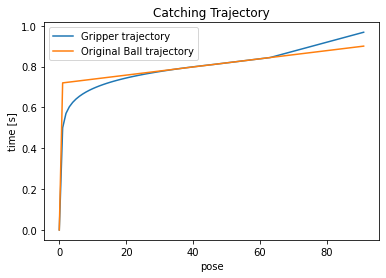

In [ ]:
X_catch, time_catch, gripper_knots, gripper_t_lst = MakeCatchingTrajectory(None, None,0.0, [0.4,0.5, 1.5], [-1, -1, 3], RigidTransform(), do_plots = True)

### 5. If you can Catch, you can throw
After developing our catching framework, we noticed that if you played the simulation backwards it looked like a throw!
So we figured that for a desired position and velocity of the ball, we just reverse the velocity and make a catching problem out of it.
After finding a nice plan, we reverse the time and the poses to get the throwing trajectory. YES ITS THAT SIMPLE!

In [ ]:
def MakeThrowingTrajectory(X_Winit, V_Winit, t_init, p_init, v_init, offset, time_delta = 0.002, do_plots = False):
    #throwing is reverse catching as long as there is no drag!
    #reverse init velocity 
    v_init_catch = list(-np.array(v_init))
    X_catch, time_catch, gripper_knots, gripper_t_lst = MakeCatchingTrajectory(X_Winit, V_Winit, 0, p_init, v_init_catch, offset)

    #now we reverse everything! 
    X_throw = X_catch[::-1]
    gripper_knots_throw =gripper_knots[::-1]

    time_throw = list((time_catch[-1] - np.array(time_catch))[::-1] + t_init)
    gripper_t_throw = list((gripper_t_lst[-1] - np.array(gripper_t_lst))[::-1] +t_init)

    if do_plots:
        plt.plot(range(len(time_catch)), time_catch, label = 'Catching trajectory')
        plt.plot(range(len(time_throw)), list(time_throw), label = 'Throwing trajectory')
        plt.legend()
        plt.xlabel("pose")
        plt.ylabel("time [s]")
        plt.title("Throwing vs Catching Trajectory")
        plt.show()

    
    return X_throw, time_throw, gripper_knots_throw, gripper_t_throw

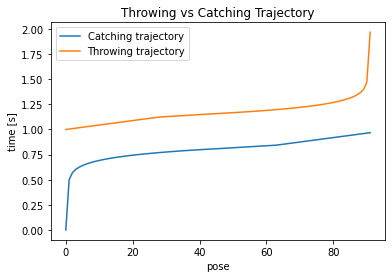

In [ ]:
X_catch, time_catch, gripper_knots, gripper_t_lst = MakeThrowingTrajectory(0, 0,1, [0.4,0.5, 1.5], [1, 1, -3], RigidTransform(), do_plots = True)

# LET's Catch!

In [ ]:
def MakeCatchingEnvironmentIntegrator(p_init,v_init, real_time=1.0):
    offset = RigidTransform()
    time_step = 0.002
    builder = DiagramBuilder()
    station_diagram, plant, integrator = MakeManipulationStation(time_step,offset)
    station = builder.AddSystem(station_diagram)

    sphere = plant.GetBodyByName("sphere")  

    visualizer = MeshcatVisualizerCpp.AddToBuilder(
        builder, station.GetOutputPort("geometry_query"), meshcat)


    # Find the initial pose of the gripper (as set in the default Context)
    temp_context = station_diagram.CreateDefaultContext()
    temp_plant_context = plant.GetMyContextFromRoot(temp_context)
    
    # Make Trajectories
    X_Winit = plant.EvalBodyPoseInWorld(temp_plant_context, plant.GetBodyByName("body"))
    V_Winit = plant.EvalBodySpatialVelocityInWorld(temp_plant_context, plant.GetBodyByName("body")) 
    t_init = 0.0

    ####### Make actual trajectory ######
    X_catch, time_catch, gripper_knots, gripper_t_lst = MakeCatchingTrajectory(X_Winit, V_Winit, t_init, p_init, v_init, offset)
    gripper_knots = np.array(gripper_knots).reshape(1,len(gripper_t_lst))
    traj = PiecewisePose.MakeLinear(time_catch, X_catch)

    traj_wsg_command = PiecewisePolynomial.FirstOrderHold(gripper_t_lst, gripper_knots)

    for i in range(len(X_catch)):
        AddMeshcatTriad(meshcat, 'pose'+str(i), X_PT=X_catch[i], opacity=0.1)
 
    pose_source = builder.AddSystem(PoseSource(traj))

    #connect Pose source with stations DiffIK
    builder.Connect(pose_source.GetOutputPort("Velocity"), station.GetInputPort("iiwa_velocity"))
    
    wsg_source = builder.AddSystem(TrajectorySource(traj_wsg_command))
    wsg_source.set_name("wsg_command")
    builder.Connect(wsg_source.get_output_port(), station.GetInputPort("wsg_position"))

    diagram = builder.Build()

    context = diagram.CreateDefaultContext()
    diagram.Publish(context)

    simulator = Simulator(diagram)
    context = simulator.get_mutable_context()
    plant_context = plant.GetMyContextFromRoot(context)

    #initial condition
    v_WSphere = SpatialVelocity(w=[0, 0, 0], v=v_init)
    x_WSphere = RigidTransform(p=p_init)
    plant.SetFreeBodyPose(plant_context, sphere, x_WSphere)
    plant.SetFreeBodySpatialVelocity(context=plant_context, body=sphere, V_WB=v_WSphere)

    #init integrator
    q0 = station.GetOutputPort("iiwa_position_measured").Eval(temp_context)
    integrator.set_integral_value(integrator.GetMyContextFromRoot(simulator.get_mutable_context()), q0)

    simulator.set_target_realtime_rate(real_time)
    simulator.AdvanceTo(1e-6)
    
    return simulator, plant, visualizer

In [ ]:
meshcat.Delete()
p_sphere_init = [0.4,0.5, 1.5]
v_sphere_init = [-1, -1, 3]
simulator, plant, visualizer = MakeCatchingEnvironmentIntegrator(p_sphere_init,v_sphere_init)

In [ ]:
visualizer.StartRecording()
simulator.AdvanceTo(6)
visualizer.PublishRecording()

# Catch and Throwback

In [ ]:
def MakeThrowbackEnvironment(p_init,v_init):
    offset = RigidTransform()
    time_step = 0.002
    builder = DiagramBuilder()
    station_diagram, plant, integrator = MakeManipulationStation(time_step,offset)
    station = builder.AddSystem(station_diagram)

    sphere = plant.GetBodyByName("sphere")  

    visualizer = MeshcatVisualizerCpp.AddToBuilder(
        builder, station.GetOutputPort("geometry_query"), meshcat)


    # Find the initial pose of the gripper (as set in the default Context)
    temp_context = station_diagram.CreateDefaultContext()
    temp_plant_context = plant.GetMyContextFromRoot(temp_context)
    
    # Make Trajectories
    X_Winit = plant.EvalBodyPoseInWorld(temp_plant_context, plant.GetBodyByName("body"))
    V_Winit = plant.EvalBodySpatialVelocityInWorld(temp_plant_context, plant.GetBodyByName("body")) 
    t_init = 0.0

    t_pause = 1

    ####### Make actual trajectory ######
    X_catch, time_catch, gripper_knots, gripper_t_lst = MakeCatchingTrajectory(X_Winit, V_Winit, t_init, p_init, v_init, offset, 0.005)
    X_throw, time_throw, gripper_knots_throw, gripper_t_lst_throw = MakeThrowingTrajectory(X_Winit, V_Winit, time_catch[-1] + t_pause + 0.1, p_init, list(-np.array(v_init)), offset)
    
    #concatenate
    X_combined = X_catch + [X_catch[-1]] + X_throw
    time_combined = time_catch + [time_catch[-1]+t_pause] + time_throw

    gripper_knots_combined = gripper_knots[:-1] + [gripper_knots[-1]] + gripper_knots_throw
    gripper_t_combined = gripper_t_lst[:-1]  + [gripper_t_lst[-1]+t_pause] + gripper_t_lst_throw
    
    gripper_knots_combined = np.array(gripper_knots_combined).reshape(1,len(gripper_t_combined))
    
    traj = PiecewisePose.MakeLinear(time_combined, X_combined)
    traj_wsg_command = PiecewisePolynomial.FirstOrderHold(gripper_t_combined, gripper_knots_combined)
    
    pose_source = builder.AddSystem(PoseSource(traj))

    #connect Pose source with stations DiffIK
    builder.Connect(pose_source.GetOutputPort("Velocity"), station.GetInputPort("iiwa_velocity"))
    
    wsg_source = builder.AddSystem(TrajectorySource(traj_wsg_command))
    wsg_source.set_name("wsg_command")
    builder.Connect(wsg_source.get_output_port(), station.GetInputPort("wsg_position"))

    diagram = builder.Build()

    context = diagram.CreateDefaultContext()
    diagram.Publish(context)

    simulator = Simulator(diagram)
    context = simulator.get_mutable_context()
    plant_context = plant.GetMyContextFromRoot(context)

    #initial condition
    v_WSphere = SpatialVelocity(w=[0, 0, 0], v=v_init)
    x_WSphere = RigidTransform(p=p_init)
    plant.SetFreeBodyPose(plant_context, sphere, x_WSphere)
    plant.SetFreeBodySpatialVelocity(context=plant_context, body=sphere, V_WB=v_WSphere)

    #init integrator
    q0 = station.GetOutputPort("iiwa_position_measured").Eval(temp_context)
    integrator.set_integral_value(integrator.GetMyContextFromRoot(simulator.get_mutable_context()), q0)

    simulator.set_target_realtime_rate(1.0)
    simulator.AdvanceTo(1e-6)
    
    return simulator, plant, visualizer

In [ ]:
meshcat.Delete()
p_sphere_init = [0.4,0.5, 1.5]
v_sphere_init = [-1, -1, 3]
sphere_mu = 10 #need to set this higher because of non symmetric release and catch. Will fix in future
simulator, plant, visualizer = MakeThrowbackEnvironment(p_sphere_init,v_sphere_init)

In [ ]:
visualizer.StartRecording()
simulator.AdvanceTo(8)
visualizer.PublishRecording()

# Throw and Catch with two robot arms

In [ ]:
class ThrowBackSCL(LeafSystem):
    def __init__(self, X_Winit, V_Winit, offset, t_init):
        LeafSystem.__init__(self)
        self.X_Winit = X_Winit
        self.V_Winit = V_Winit
        self.offset = offset
        self.t_init = t_init

        self.iiwa_traj = PiecewisePose.MakeLinear([0.0, t_init + 1], [X_Winit, X_Winit])
        self.gripper_traj = PiecewisePolynomial.FirstOrderHold([0.0, t_init + 1], np.array([0.1,0.1]).reshape(1,2))

        self.V_port = self.DeclareAbstractInputPort("V_WO", AbstractValue.Make(SpatialVelocity()))
        self.X_port = self.DeclareAbstractInputPort("X_WO",AbstractValue.Make(RigidTransform()))

        self.gripper_output = self.DeclareVectorOutputPort("gripper", self.gripper_traj.rows(), self.CalcGripperOutput)
        self.iiwa_velocity_output = self.DeclareVectorOutputPort("V_WE_desired", 6, self.CalcVelocity)

    
    def CalcVelocity(self, context, output):
        self.UpdatePlan(context)
        output.set_value(self.iiwa_traj.GetVelocity(context.get_time()))
    
    def CalcGripperOutput(self, context, output):
        self.UpdatePlan(context)
        output.SetFromVector(self.gripper_traj.value(context.get_time()))
    
    def UpdatePlan(self, context):
        current_time = context.get_time()
        if current_time > self.t_init:
            #is the ball coming towards the robot? 
            X = self.X_port.Eval(context)
            p_init = X.translation()
            V = self.V_port.Eval(context)
            v_init = V.translational()

            #is the ball within the sphere of interest?
            p_OS = self.offset.translation() - p_init

            if p_OS[:2].dot(v_init[:2]) > 0 and np.linalg.norm(v_init[:2]) > 0 and np.linalg.norm(p_OS) < 3:
                #its approaching lets update!
                ####### Make actual trajectory ######
                t_pause = 1
                X_catch, time_catch, gripper_knots, gripper_t_lst = MakeCatchingTrajectory(self.X_Winit, self.V_Winit, current_time, p_init, v_init, self.offset)
                X_throw, time_throw, gripper_knots_throw, gripper_t_lst_throw = MakeThrowingTrajectory(self.X_Winit, self.V_Winit, time_catch[-1] +t_pause+ 0.1, p_init, list(-np.array(v_init)), self.offset)
    
                #concatenate
                X_combined = X_catch + [X_catch[-1]] + X_throw
                time_combined = time_catch + [time_catch[-1]+t_pause] + time_throw

                gripper_knots_combined = gripper_knots[:-1] + [gripper_knots[-1]] + gripper_knots_throw
                gripper_t_combined = gripper_t_lst[:-1]  + [gripper_t_lst[-1]+t_pause] + gripper_t_lst_throw
    
                gripper_knots_combined = np.array(gripper_knots_combined).reshape(1,len(gripper_t_combined))
                
                #update trajectory 
                self.iiwa_traj = PiecewisePose.MakeLinear(time_combined, X_combined)
                self.gripper_traj  = PiecewisePolynomial.FirstOrderHold(gripper_t_combined, gripper_knots_combined)


                #update time
                self.t_init = time_combined[-1]


class PoseAndVelocityExtractor(LeafSystem):
    def __init__(self, object_index):
        LeafSystem.__init__(self)
        self.object_index = int(object_index)

        self.Xs_port = self.DeclareAbstractInputPort("body_poses", AbstractValue.Make([RigidTransform()]))
        self.Vs_port = self.DeclareAbstractInputPort("body_spatial_velocities", AbstractValue.Make([SpatialVelocity()]))
        
        self.DeclareAbstractOutputPort("Pose", lambda: AbstractValue.Make(RigidTransform()),self.CalcPose)
        self.DeclareAbstractOutputPort("Velocity", lambda: AbstractValue.Make(SpatialVelocity()),self.CalcVelocity)
    
    def CalcPose(self, context, output):
        X = self.Xs_port.Eval(context)[self.object_index]
        output.set_value(X)
    
    def CalcVelocity(self, context, output):
        V = self.Vs_port.Eval(context)[self.object_index]
        output.set_value(V)

In [ ]:
def MakeThrowAndCatchEnvironment(p_init,v_init):
    time_step = 0.002
    builder = DiagramBuilder()

    plant, scene_graph =AddMultibodyPlantSceneGraph(
        builder, time_step=time_step)

    ##################### ADD Ball and Environment #######################
    # add ground
    Parser(plant).AddModelFromFile('ground.urdf', "ground")
    # add tennisball
    AddShape(plant, Sphere(sphere_r), name="sphere", mass=sphere_mass, mu=sphere_mu, color=sphere_color)
    sphere = plant.GetBodyByName("sphere")     

    ##################### ADD ROBOT A #######################
    offset_A = RigidTransform(RotationMatrix.MakeZRotation(-np.pi/2), p=[-1.5,0,0])
    iiwa_A = AddIiwa(plant, offset = offset_A, name = "iiwa_A")
    wsg_A = AddWsg(plant, iiwa_A, name = "gripper_A")

    ##################### ADD ROBOT B #######################
    offset_B = RigidTransform(RotationMatrix.MakeZRotation(-np.pi/2), p=[1.5,0,0])
    iiwa_B = AddIiwa(plant, offset = offset_B, name = "iiwa_B")
    wsg_B = AddWsg(plant, iiwa_B, name = "gripper_B")

    plant.Finalize()

    num_iiwa_positions = plant.num_positions(iiwa_A)
    num_iiwa_velocities = plant.num_velocities(iiwa_A)

    iiwa_state_A = builder.AddSystem(PassThrough(num_iiwa_positions +  num_iiwa_velocities))
    iiwa_velocity_A = builder.AddSystem(PassThrough(6))
    builder.ExportInput(iiwa_velocity_A.get_input_port(), "iiwa_velocity_A")

    iiwa_state_B = builder.AddSystem(PassThrough(num_iiwa_positions +  num_iiwa_velocities))
    iiwa_velocity_B = builder.AddSystem(PassThrough(6))
    builder.ExportInput(iiwa_velocity_B.get_input_port(), "iiwa_velocity_B")

    # Export the iiwa "state" outputs.
    demux_A = builder.AddSystem(Demultiplexer(
        2 * num_iiwa_positions, num_iiwa_positions))
    builder.Connect(plant.get_state_output_port(iiwa_A), demux_A.get_input_port())

    demux_B = builder.AddSystem(Demultiplexer(
        2 * num_iiwa_positions, num_iiwa_positions))
    builder.Connect(plant.get_state_output_port(iiwa_B), demux_B.get_input_port())

    builder.ExportOutput(demux_A.get_output_port(0), "iiwa_position_measured_A")
    builder.ExportOutput(demux_B.get_output_port(0), "iiwa_position_measured_B")
    #builder.ExportOutput(demux_A.get_output_port(1), "iiwa_velocity_estimated")
    #builder.ExportOutput(plant.get_state_output_port(iiwa_A), "iiwa_state_estimated")

    # Make the plant for the iiwa controller to use.
    controller_plant_A = MultibodyPlant(time_step=time_step)
    controller_iiwa_A = AddIiwa(controller_plant_A, offset = offset_A)
    AddWsg(controller_plant_A, controller_iiwa_A, welded=True)
    controller_plant_A.Finalize()
    
    controller_plant_B = MultibodyPlant(time_step=time_step)
    controller_iiwa_B = AddIiwa(controller_plant_B, offset = offset_B)
    AddWsg(controller_plant_B, controller_iiwa_B, welded=True)
    controller_plant_B.Finalize()


    # Add the iiwa controller
    iiwa_controller_A = builder.AddSystem(
        InverseDynamicsController(
            controller_plant_A,
            kp=[100]*num_iiwa_positions,
            ki=[1]*num_iiwa_positions,
            kd=[20]*num_iiwa_positions,
            has_reference_acceleration=True))
    iiwa_controller_A.set_name("iiwa_controller_A")
    builder.Connect(
        plant.get_state_output_port(iiwa_A), iiwa_controller_A.get_input_port_estimated_state())
    
    iiwa_controller_B = builder.AddSystem(
        InverseDynamicsController(
            controller_plant_B,
            kp=[100]*num_iiwa_positions,
            ki=[1]*num_iiwa_positions,
            kd=[20]*num_iiwa_positions,
            has_reference_acceleration=True))
    iiwa_controller_B.set_name("iiwa_controller_B")
    builder.Connect(
        plant.get_state_output_port(iiwa_B), iiwa_controller_B.get_input_port_estimated_state())

    # Add in the feed-forward torque
    adder_A = builder.AddSystem(Adder(2, num_iiwa_positions))
    builder.Connect(iiwa_controller_A.get_output_port_control(),
                    adder_A.get_input_port(0))
    # Use a PassThrough to make the port optional (it will provide zero values if not connected).
    torque_passthrough_A = builder.AddSystem(
        PassThrough([0]*num_iiwa_positions))
    builder.Connect(torque_passthrough_A.get_output_port(), adder_A.get_input_port(1))
    #builder.ExportInput(torque_passthrough.get_input_port(), "iiwa_feedforward_torque")
    builder.Connect(adder_A.get_output_port(), plant.get_actuation_input_port(iiwa_A))

    builder.Connect(iiwa_state_A.get_output_port(), iiwa_controller_A.get_input_port_desired_state())

    adder_B = builder.AddSystem(Adder(2, num_iiwa_positions))
    builder.Connect(iiwa_controller_B.get_output_port_control(),
                    adder_B.get_input_port(0))
    # Use a PassThrough to make the port optional (it will provide zero values if not connected).
    torque_passthrough_B = builder.AddSystem(
        PassThrough([0]*num_iiwa_positions))
    builder.Connect(torque_passthrough_B.get_output_port(), adder_B.get_input_port(1))
    #builder.ExportInput(torque_passthrough.get_input_port(), "iiwa_feedforward_torque")
    builder.Connect(adder_B.get_output_port(), plant.get_actuation_input_port(iiwa_B))

    builder.Connect(iiwa_state_B.get_output_port(), iiwa_controller_B.get_input_port_desired_state())


    # DiffIK Controller
    plant_robot_A, _ = CreateIiwaControllerPlant(offset = offset_A) #create for controller
    plant_robot_B, _ = CreateIiwaControllerPlant(offset = offset_B) #create for controller

    params = DifferentialInverseKinematicsParameters(plant_robot_A.num_positions(),plant_robot_A.num_velocities())
    params.set_timestep(time_step)
    
    #iiwa7_velocity_limits = np.array([1.71, 1.71,1.745, 2.26, 2.44, 3.14, 3.14])
    params.set_joint_velocity_limits((plant_robot_A.GetVelocityLowerLimits(),plant_robot_A.GetVelocityUpperLimits()))

    params.set_joint_position_limits((plant_robot_A.GetPositionLowerLimits(),plant_robot_A.GetPositionUpperLimits()))

    gripper_frame_A = plant_robot_A.GetBodyByName("body").body_frame()
    robot_context_A = plant_robot_A.CreateDefaultContext()

    gripper_frame_B = plant_robot_B.GetBodyByName("body").body_frame()
    robot_context_B = plant_robot_B.CreateDefaultContext()

    DiffIK_A = builder.AddSystem(DifferentialIKCL(plant_robot_A, gripper_frame_A, params))                  
    #connect DiffIK
    builder.Connect(iiwa_velocity_A.get_output_port(), DiffIK_A.GetInputPort("V_WE_desired"))
    builder.Connect(demux_A.get_output_port(0), DiffIK_A.GetInputPort("iiwa_position"))

    integrator_A = builder.AddSystem(Integrator(7))
    integrator.set_name("integrator_A")
    builder.Connect(DiffIK_A.get_output_port(), integrator_A.get_input_port())

    mux_A = builder.AddSystem(Multiplexer([num_iiwa_positions, num_iiwa_velocities]))
    builder.Connect(integrator_A.get_output_port(), mux_A.get_input_port(0))
    builder.Connect(DiffIK_A.get_output_port(), mux_A.get_input_port(1) )
    builder.Connect(mux_A.get_output_port(), iiwa_state_A.get_input_port())

    #accelerations
    acceleration_A = builder.AddSystem(DiscreteDerivative(7, time_step))
    builder.Connect(DiffIK_A.get_output_port(),acceleration_A.get_input_port())
    builder.Connect(acceleration_A.get_output_port(),iiwa_controller_A.get_input_port_desired_acceleration())

    DiffIK_B = builder.AddSystem(DifferentialIKCL(plant_robot_B, gripper_frame_B, params))                  
    #connect DiffIK
    builder.Connect(iiwa_velocity_B.get_output_port(), DiffIK_B.GetInputPort("V_WE_desired"))
    builder.Connect(demux_B.get_output_port(0), DiffIK_B.GetInputPort("iiwa_position"))

    integrator_B = builder.AddSystem(Integrator(7))
    integrator.set_name("integrator_B")
    builder.Connect(DiffIK_B.get_output_port(), integrator_B.get_input_port())

    mux_B = builder.AddSystem(Multiplexer([num_iiwa_positions, num_iiwa_velocities]))
    builder.Connect(integrator_B.get_output_port(), mux_B.get_input_port(0))
    builder.Connect(DiffIK_B.get_output_port(), mux_B.get_input_port(1) )
    builder.Connect(mux_B.get_output_port(), iiwa_state_B.get_input_port())

    #accelerations
    acceleration_B = builder.AddSystem(DiscreteDerivative(7, time_step))
    builder.Connect(DiffIK_B.get_output_port(),acceleration_B.get_input_port())
    builder.Connect(acceleration_B.get_output_port(),iiwa_controller_B.get_input_port_desired_acceleration())


    # Wsg controller.
    wsg_controller_A = builder.AddSystem(SchunkWsgPositionController(kp_command=2000.0, kd_command=5.0, kp_constraint=2000.0, kd_constraint=5.0, default_force_limit=40.0))
    wsg_controller_A.set_name("wsg_controller_A")
    builder.Connect(wsg_controller_A.get_generalized_force_output_port(),             
                    plant.get_actuation_input_port(wsg_A))
    builder.Connect(plant.get_state_output_port(wsg_A), wsg_controller_A.get_state_input_port())
    builder.ExportInput(wsg_controller_A.get_desired_position_input_port(), "wsg_position_A")
    #builder.ExportInput(wsg_controller.get_force_limit_input_port(), "wsg_force_limit")
    wsg_mbp_state_to_wsg_state_A = builder.AddSystem(
        MakeMultibodyStateToWsgStateSystem())
    builder.Connect(plant.get_state_output_port(wsg_A), wsg_mbp_state_to_wsg_state_A.get_input_port())
    #builder.ExportOutput(wsg_mbp_state_to_wsg_state_A.get_output_port(), "wsg_state_measured")
    #builder.ExportOutput(wsg_controller.get_grip_force_output_port(), "wsg_force_measured")

    # Wsg controller.
    wsg_controller_B = builder.AddSystem(SchunkWsgPositionController(kp_command=2000.0, kd_command=5.0, kp_constraint=2000.0, kd_constraint=5.0, default_force_limit=40.0))
    wsg_controller_B.set_name("wsg_controller_B")
    builder.Connect(wsg_controller_B.get_generalized_force_output_port(),             
                    plant.get_actuation_input_port(wsg_B))
    builder.Connect(plant.get_state_output_port(wsg_B), wsg_controller_B.get_state_input_port())
    builder.ExportInput(wsg_controller_B.get_desired_position_input_port(), "wsg_position_B")
    #builder.ExportInput(wsg_controller.get_force_limit_input_port(), "wsg_force_limit")
    wsg_mbp_state_to_wsg_state_B = builder.AddSystem(
        MakeMultibodyStateToWsgStateSystem())
    builder.Connect(plant.get_state_output_port(wsg_B), wsg_mbp_state_to_wsg_state_B.get_input_port())
    #builder.ExportOutput(wsg_mbp_state_to_wsg_state_A.get_output_port(), "wsg_state_measured")
    #builder.ExportOutput(wsg_controller.get_grip_force_output_port(), "wsg_force_measured")

    builder.ExportOutput(plant.get_body_poses_output_port(), "body_poses")
    builder.ExportOutput(plant.get_body_spatial_velocities_output_port(), "body_velocities")

    ######################################################################
    visualizer = MeshcatVisualizerCpp.AddToBuilder(builder, scene_graph, meshcat)
    
    diagram = builder.Build()

    # Find the initial pose of the gripper (as set in the default Context)
    station_context = diagram.CreateDefaultContext()
    station_plant_context = plant.GetMyContextFromRoot(station_context)
    
    X_Winit_A = plant.EvalBodyPoseInWorld(station_plant_context, plant.GetBodyByName("body", wsg_A))
    V_Winit_A = plant.EvalBodySpatialVelocityInWorld(station_plant_context, plant.GetBodyByName("body",wsg_A)) 

    X_Winit_B = plant.EvalBodyPoseInWorld(station_plant_context, plant.GetBodyByName("body",wsg_B))
    V_Winit_B = plant.EvalBodySpatialVelocityInWorld(station_plant_context, plant.GetBodyByName("body",wsg_B)) 

    #########################################################
    builder = DiagramBuilder()
    builder.AddSystem(diagram)
    
    #connect the Throwback controller!

    throwback_controller_A = builder.AddSystem(ThrowBackSCL(X_Winit_A, V_Winit_A, offset_A, 0))


    builder.Connect(throwback_controller_A.GetOutputPort("V_WE_desired"), diagram.GetInputPort("iiwa_velocity_A"))
    builder.Connect(throwback_controller_A.GetOutputPort("gripper"), diagram.GetInputPort("wsg_position_A"))

    extractor = builder.AddSystem(PoseAndVelocityExtractor(int(sphere.index())))
    builder.Connect(diagram.GetOutputPort("body_poses"), extractor.GetInputPort("body_poses"))
    builder.Connect(diagram.GetOutputPort("body_velocities"), extractor.GetInputPort("body_spatial_velocities"))

    builder.Connect(extractor.GetOutputPort("Pose"), throwback_controller_A.GetInputPort("X_WO"))
    builder.Connect(extractor.GetOutputPort("Velocity"), throwback_controller_A.GetInputPort("V_WO"))

    throwback_controller_B = builder.AddSystem(ThrowBackSCL(X_Winit_B, V_Winit_B, offset_B, 0))

    builder.Connect(throwback_controller_B.GetOutputPort("V_WE_desired"), diagram.GetInputPort("iiwa_velocity_B"))
    builder.Connect(throwback_controller_B.GetOutputPort("gripper"), diagram.GetInputPort("wsg_position_B"))

    builder.Connect(extractor.GetOutputPort("Pose"), throwback_controller_B.GetInputPort("X_WO"))
    builder.Connect(extractor.GetOutputPort("Velocity"), throwback_controller_B.GetInputPort("V_WO"))



    q0_A = diagram.GetOutputPort("iiwa_position_measured_A").Eval(station_context)
    q0_B = diagram.GetOutputPort("iiwa_position_measured_B").Eval(station_context)

    diagram = builder.Build()

    context = diagram.CreateDefaultContext()
    diagram.Publish(context)

    simulator = Simulator(diagram)
    context = simulator.get_mutable_context()
    plant_context = plant.GetMyContextFromRoot(context)

    #initial condition
    v_WSphere = SpatialVelocity(w=[0, 0, 0], v=v_init)
    x_WSphere = RigidTransform(p=p_init)
    plant.SetFreeBodyPose(plant_context, sphere, x_WSphere)
    plant.SetFreeBodySpatialVelocity(context=plant_context, body=sphere, V_WB=v_WSphere)

    #init integrator

    integrator_A.set_integral_value(integrator_A.GetMyContextFromRoot(simulator.get_mutable_context()), q0_A)
    integrator_B.set_integral_value(integrator_B.GetMyContextFromRoot(simulator.get_mutable_context()), q0_B)

    simulator.set_target_realtime_rate(1.0)
    simulator.AdvanceTo(1e-6)
    
    return simulator, plant, visualizer

In [ ]:
meshcat.Delete()
p_sphere_init = [1.5,0, 0.4]
v_sphere_init = [-3, 0, 6]

p_sphere_init = [0,0, 2]
v_sphere_init = [-3, 0, 0]
sphere_mu = 10 #need to set this higher because of non symmetric release and catch. Will fix in future
simulator, plant, visualizer = MakeThrowAndCatchEnvironment(p_sphere_init,v_sphere_init)



In [ ]:
visualizer.StartRecording()
simulator.AdvanceTo(12)
visualizer.PublishRecording()

In [ ]:
#html = meshcat.StaticHtml() you can save the simulation!

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=3ffed1bb-60d7-4025-872d-1c12596bf740' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>